## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.datasets import make_regression, make_classification, load_digits
from sklearn.model_selection import train_test_split

from sparse_model import MyModel, SparseLinear
from sparse_model import convert_to_sparse
from train import train_one_model, valid_model
from pruning import evaluate_sensitivity, do_pruning
from speed_metrics import inference_time_over_params, get_number_of_params
from speed_metrics import get_avg_inference_time


SEED = 8642
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cpu')  
# mps_deivce = torch.device('mps')
device

device(type='cpu')

In [2]:
layer_sizes = {
    'small': [64, 20, 10, 1], 
    'base': [64, 100, 50, 1],
    'large': [64, 200, 100, 1]
}

metric_table = {
    'basic': [],
    'SensitivityBased': [],
    'L1': []
}

## Speed tests

### sklearn regression

#### basic model

In [3]:
def get_regression_dataloaders(layers, n_samples=1000, batch_size=32):
    X, y = make_regression(n_samples=n_samples, n_features=layers[0], 
                           n_informative=layers[0], random_state=SEED)
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float()
    train_dataset, test_dataset = train_test_split(list(zip(X, y)), test_size=0.2, random_state=SEED)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

In [4]:
layers = layer_sizes['base']

train_loader, val_loader = get_regression_dataloaders(layers)
criterion = nn.MSELoss()
model = MyModel(layers).to(device)
get_number_of_params(model)

11601

Training Progress:  10%|█         | 50/500 [00:00<00:04, 107.21it/s]


Early stopping triggered


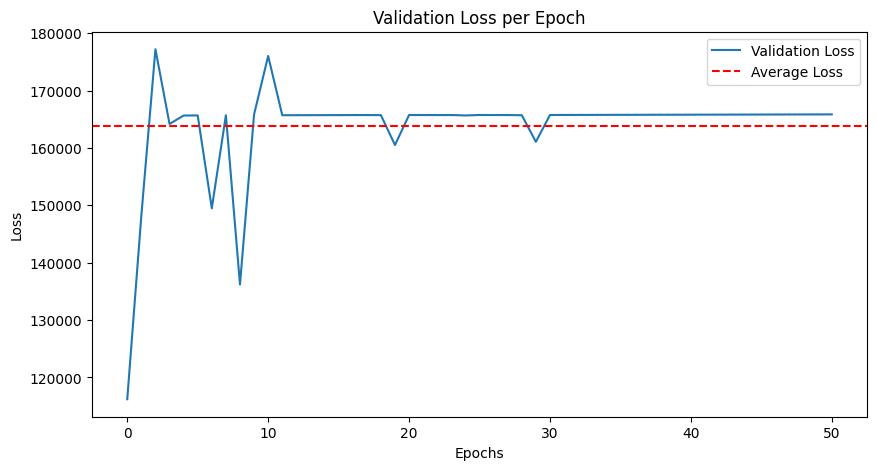

116197.76785714286

In [5]:
train_one_model(model, train_loader, val_loader, device, 
                epochs=500, criterion=criterion, patience=50)

In [6]:
valid_model(model, val_loader, criterion, device)

165855.19642857142

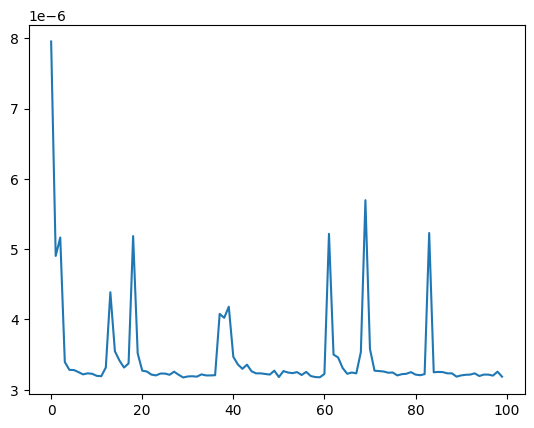

In [7]:
itop = [inference_time_over_params(model, val_loader, device)
        for _ in range(100)]
metric_table['basic'].append(np.mean(itop))
plt.plot(itop)

#### sensitivity pruning

In [8]:
sensitivity = evaluate_sensitivity(model, val_loader, criterion, device)
pruned_model_sens = do_pruning(model, pruning_type="SensitivityBased", sensitivity=sensitivity, amount=0.2, logs=False).to(device)
valid_model(pruned_model_sens, val_loader, criterion, device)

165854.76785714287

Training Progress:  10%|█         | 100/1000 [00:01<00:11, 76.49it/s]

Early stopping triggered


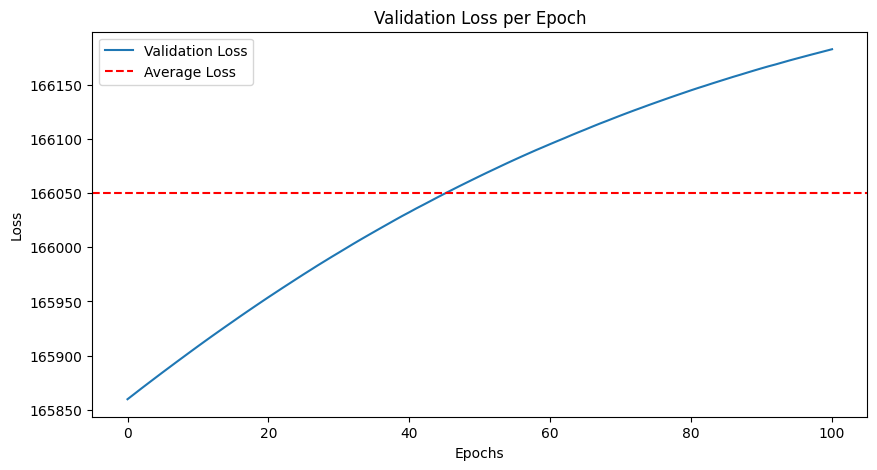

165859.80357142858

In [9]:
sparse_model_sens = convert_to_sparse(pruned_model_sens)
train_one_model(sparse_model_sens, train_loader, val_loader, device, 
                epochs=1000, criterion=criterion, patience=100)

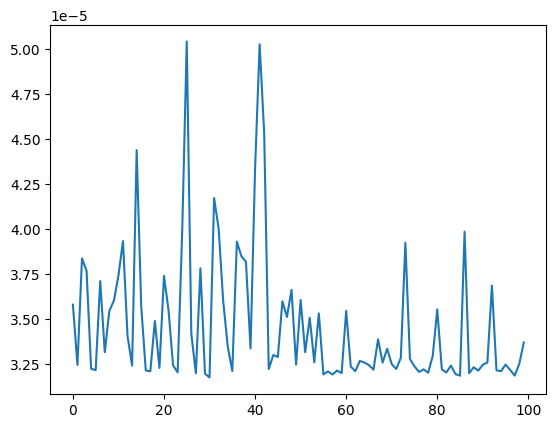

In [10]:
itop = [inference_time_over_params(sparse_model_sens, val_loader, device)
        for _ in range(100)]
metric_table['SensitivityBased'].append(np.mean(itop))
plt.plot(itop)

#### l1 pruning

In [11]:
pruned_model_l1 = do_pruning(model, pruning_type="L1", amount=0.2, logs=False).to(device)
valid_model(pruned_model_l1, val_loader, criterion, device)

165855.19642857142

Training Progress:  10%|█         | 100/1000 [00:01<00:12, 72.42it/s]


Early stopping triggered


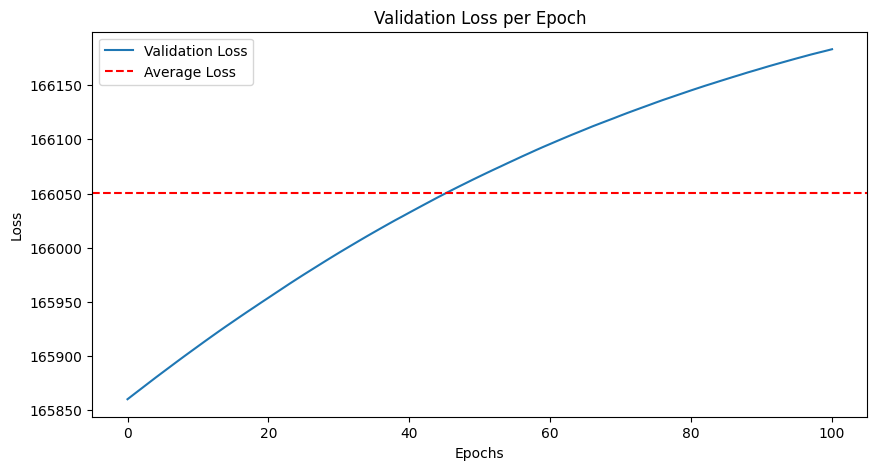

165860.2142857143

In [12]:
sparse_model_l1 = convert_to_sparse(pruned_model_l1)
train_one_model(sparse_model_l1, train_loader, val_loader, device, 
                epochs=1000, criterion=criterion, patience=100)

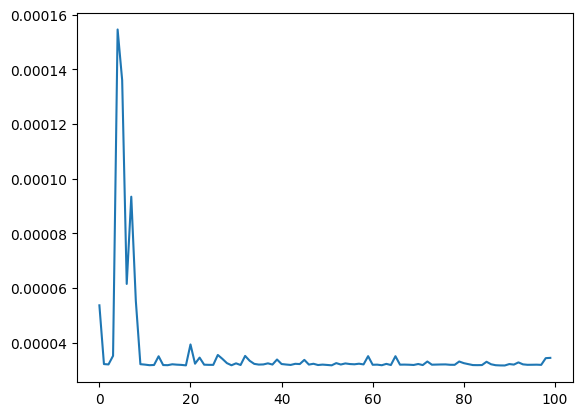

In [13]:
itop = [inference_time_over_params(sparse_model_sens, val_loader, device)
        for _ in range(100)]
metric_table['L1'].append(np.mean(itop))
plt.plot(itop)

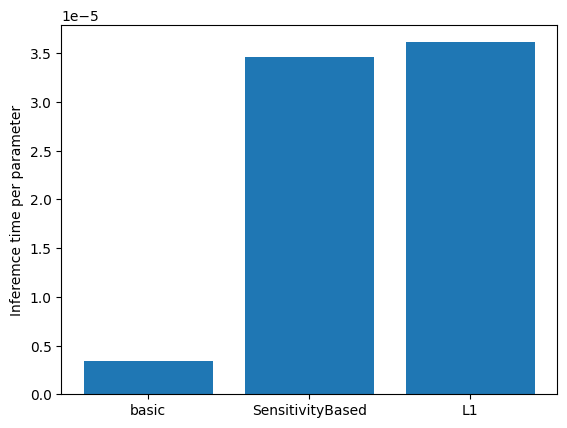

In [14]:
plt.bar(x=list(metric_table.keys()), height=np.array(list(metric_table.values())).flatten())
# plt.xlabel('Model type')
plt.ylabel('Inferemce time per parameter')
plt.show()

### sklearn classification

#### basic model

In [15]:
def get_classification_dataloaders(layers, n_samples=1000, batch_size=32):
    X, y = make_classification(n_samples=n_samples, n_features=layers[0], random_state=SEED)
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float()
    train_dataset, test_dataset = train_test_split(list(zip(X, y)), test_size=0.2, random_state=SEED)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

In [17]:
layers = layer_sizes['base']

train_loader, val_loader = get_classification_dataloaders(layers)
criterion = nn.CrossEntropyLoss()
model = MyModel(layers).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
get_number_of_params(model)

11601

Training Progress:  78%|███████▊  | 392/500 [00:03<00:00, 123.71it/s]


Early stopping triggered


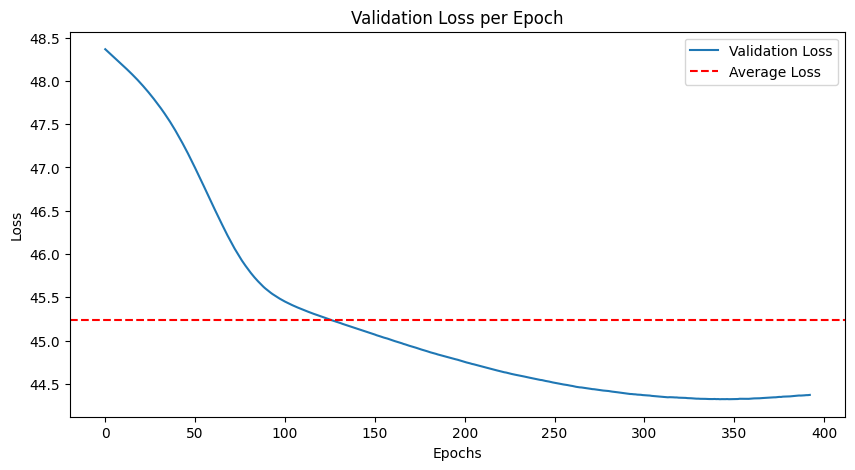

44.32314191545759

In [18]:
train_one_model(model, train_loader, val_loader, device, 
                epochs=500, criterion=criterion, 
                patience=50, optimizer=optimizer)

In [19]:
valid_model(model, val_loader, criterion, device)

44.372933523995535

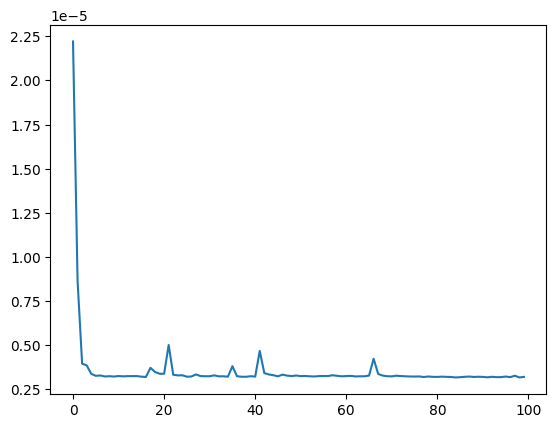

In [20]:
itop = [inference_time_over_params(model, val_loader, device)
        for _ in range(100)]
metric_table['basic'].append(np.mean(itop))
plt.plot(itop)

#### sensitivity pruning

In [21]:
sensitivity = evaluate_sensitivity(model, val_loader, criterion, device)
pruned_model_sens = do_pruning(model, pruning_type="SensitivityBased", sensitivity=sensitivity, amount=0.2, logs=False).to(device)
valid_model(pruned_model_sens, val_loader, criterion, device)

44.357151576450896

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Progress:  10%|█         | 100/1000 [00:01<00:12, 69.58it/s]


Early stopping triggered


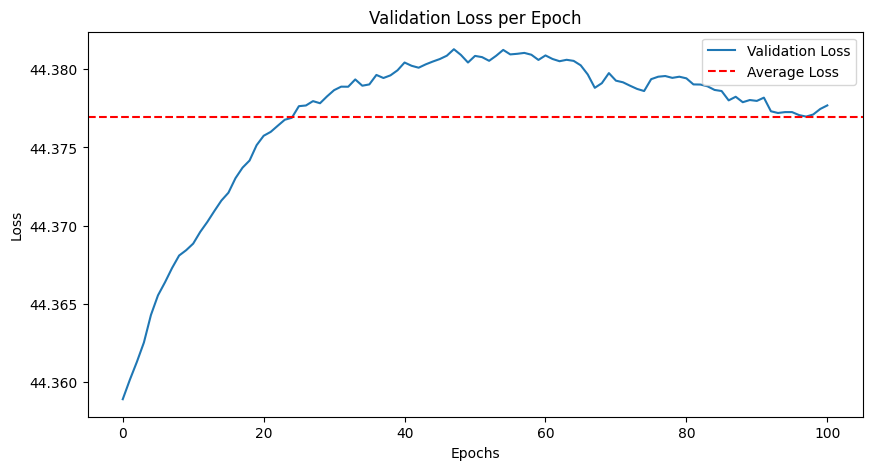

44.35890415736607

In [22]:
sparse_model_sens = convert_to_sparse(pruned_model_sens)
train_one_model(sparse_model_sens, train_loader, val_loader, device, 
                epochs=1000, criterion=criterion, patience=100)

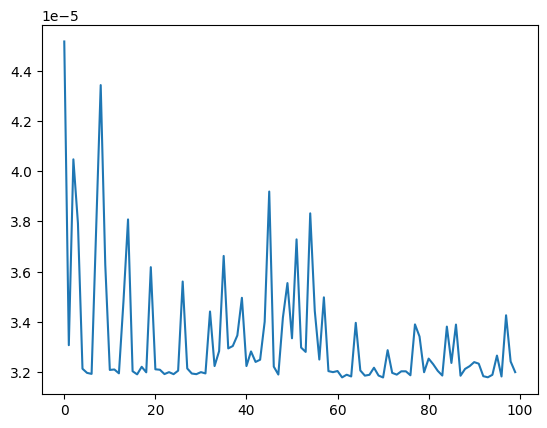

In [23]:
itop = [inference_time_over_params(sparse_model_sens, val_loader, device)
        for _ in range(100)]
metric_table['SensitivityBased'].append(np.mean(itop))
plt.plot(itop)

#### l1 pruning

In [24]:
pruned_model_l1 = do_pruning(model, pruning_type="L1", amount=0.2, logs=False).to(device)
valid_model(pruned_model_l1, val_loader, criterion, device)

44.41802542550223

Training Progress:  46%|████▌     | 459/1000 [00:06<00:07, 67.83it/s]


Early stopping triggered


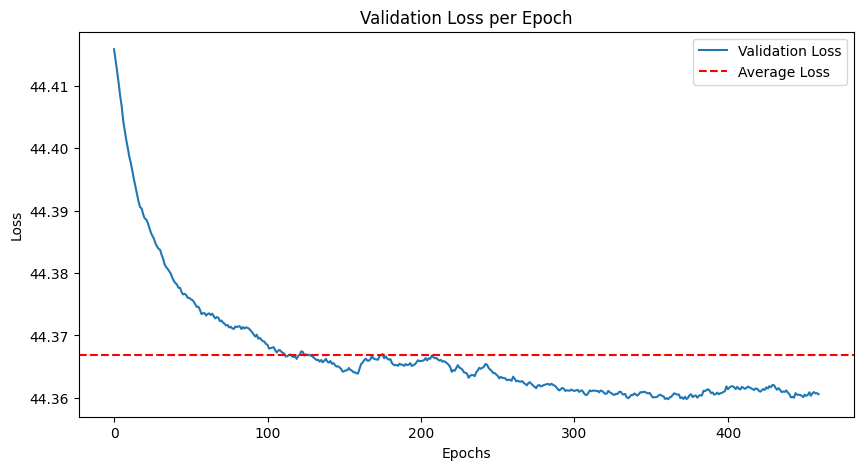

44.35981968470982

In [25]:
sparse_model_l1 = convert_to_sparse(pruned_model_l1)
train_one_model(sparse_model_l1, train_loader, val_loader, device, 
                epochs=1000, criterion=criterion, patience=100)

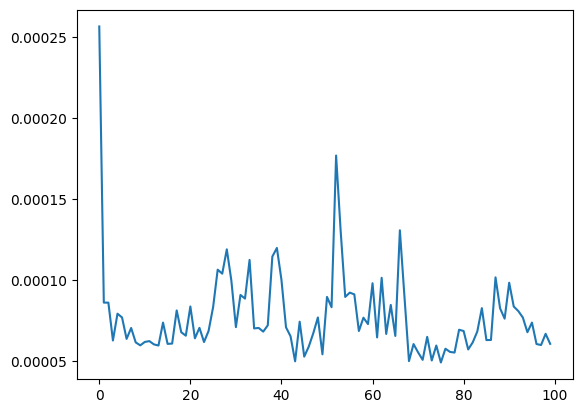

In [26]:
itop = [inference_time_over_params(sparse_model_sens, val_loader, device)
        for _ in range(100)]
metric_table['L1'].append(np.mean(itop))
plt.plot(itop)

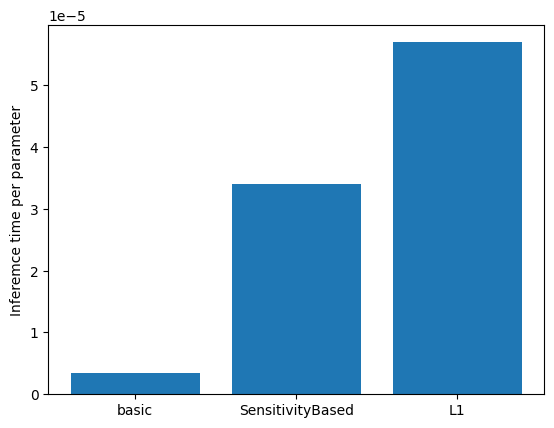

In [29]:
plt.bar(x=list(metric_table.keys()), height=np.array(list(metric_table.values())).mean(axis=1))
# plt.xlabel('Model type')
plt.ylabel('Inferemce time per parameter')
plt.show()